In [1]:
#Imports
import torch
import numpy as np
import matplotlib.pyplot as plt
import os

# Import your local modules
from models.neural_net import PINN
from data.data_generator import load_normalized_data
from utils import plot_prediction_surface, compute_rmse
from config import config

# Import training main
from main_train import main as train_model
# Import FD solver
from traditional.fd_solver import solve_heat_equation_fd


Training the model using main()
Starting PINN Training Pipeline
Using device: cpu

Loading and preprocessing data...
Loading and normalizing dataset from: D:/Programming/Summer-2025-DL-Project-PINN/data/covid_county_cases.csv
Loaded and processed: 2409352 samples
Training points: 1927481 | Test points: 481871 | Collocation points: 10000
Initializing PINN architecture...
Starting training loop...
[00000] Total Loss: 1.853012e-01 | Supervised: 1.809712e-01 | Residual: 4.329951e-03
[00500] Total Loss: 5.898105e-03 | Supervised: 5.667654e-03 | Residual: 2.304508e-04
[01000] Total Loss: 3.349819e-03 | Supervised: 3.102766e-03 | Residual: 2.470526e-04
[01500] Total Loss: 2.856130e-03 | Supervised: 2.706029e-03 | Residual: 1.501013e-04
[02000] Total Loss: 2.528815e-03 | Supervised: 2.458813e-03 | Residual: 7.000250e-05
[02500] Total Loss: 2.381909e-03 | Supervised: 2.319870e-03 | Residual: 6.203871e-05
[03000] Total Loss: 2.321744e-03 | Supervised: 2.277525e-03 | Residual: 4.421942e-05
[03500

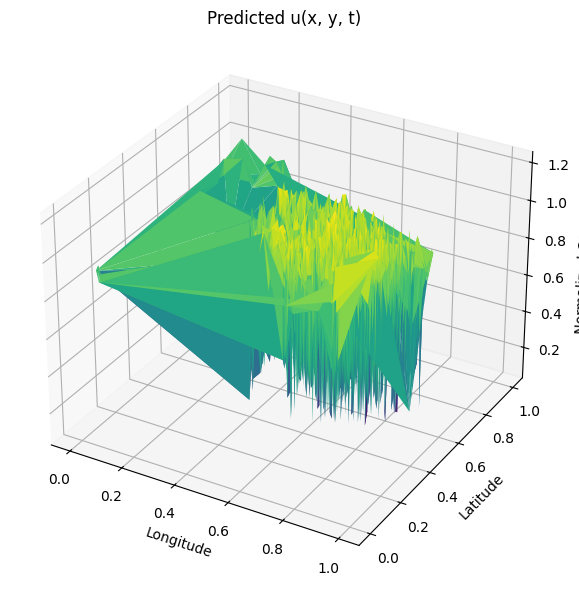

Model checkpoint saved to: D:/Programming/Summer-2025-DL-Project-PINN/checkpoints/model.pth



In [3]:
#Train the model from scratch and save it
print("Training the model using main()")
train_model()


**We load the trained PINN model using the architecture defined in neural_net.py. This allows evaluation on unseen test points.**

In [4]:
# Load trained model
print("Loading trained model...")
device = torch.device(config["device"])

model = PINN(
    input_dim=config["input_dim"],
    hidden_dim=config["hidden_dim"],
    hidden_layers=config["hidden_layers"],
    output_dim=config["output_dim"]
).to(device)

checkpoint_path = config["checkpoint_path"]
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.eval()
print(f"Model loaded from: {checkpoint_path}")


Loading trained model...
Model loaded from: D:/Programming/Summer-2025-DL-Project-PINN/checkpoints/model.pth


In [5]:
# Load test data
_, _, _, X_test, u_test = load_normalized_data(config["data_path"],
                                               n_collocation=config["n_collocation"],
                                               split_ratio=config["train_test_split"],
                                               device=device)

# Predict and compute RMSE
with torch.no_grad():
    u_pred = model(X_test)
    rmse = compute_rmse(u_pred, u_test, apply_expm1=True)
    print(f"RMSE on test set: {rmse:.6f}")
    
# Convert tensors to NumPy
X_test_np = X_test.cpu().numpy()
u_test_np = u_test.cpu().numpy()
u_pred_np = u_pred.cpu().numpy()

Loading and normalizing dataset from: D:/Programming/Summer-2025-DL-Project-PINN/data/covid_county_cases.csv
Loaded and processed: 2409352 samples
Training points: 1927481 | Test points: 481871 | Collocation points: 10000
RMSE on test set: 0.078309


**We compute RMSE to measure the model's generalization error on unseen spatiotemporal points**

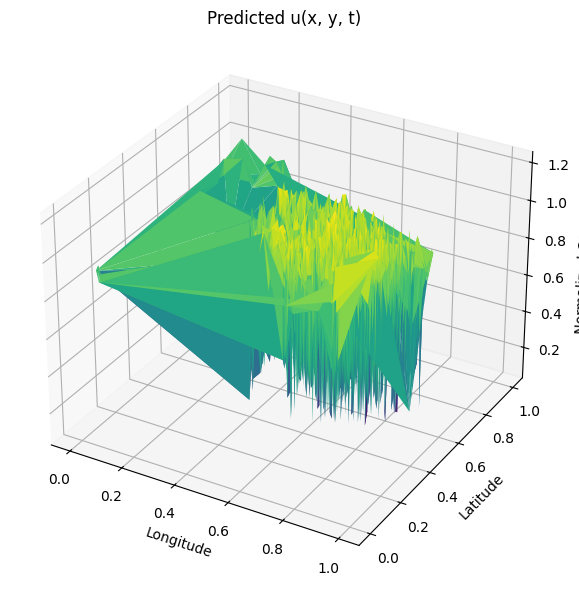

In [6]:
# Visualize surface plot
plot_prediction_surface(X_test, u_pred, title="Predicted u(x, y, t)")

**This surface plot visualizes the predicted values of the normalized case count across 3D input space (lon, lat, time)**

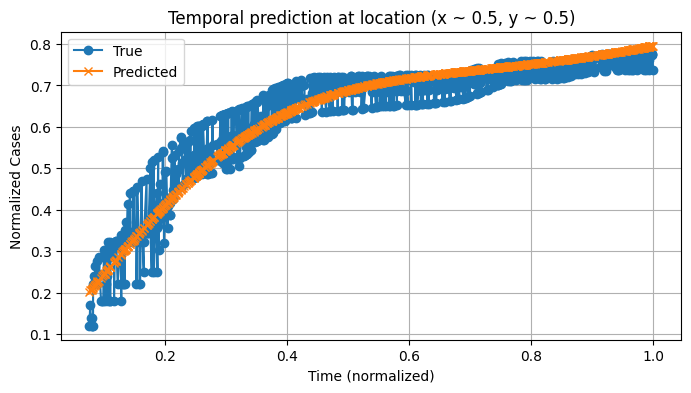

In [7]:
# Pick a location (x, y) close to [0.5, 0.5]
mask = np.abs(X_test_np[:, 0] - 0.5) < 0.01  # lon ~ 0.5
mask &= np.abs(X_test_np[:, 1] - 0.5) < 0.01  # lat ~ 0.5

x_slice = X_test_np[mask]
u_true_slice = u_test_np[mask]
u_pred_slice = u_pred_np[mask]

if len(x_slice) > 0:
    idx = np.argsort(x_slice[:, 2])  # sort by time
    plt.figure(figsize=(8, 4))
    plt.plot(x_slice[idx, 2], u_true_slice[idx], label="True", marker='o')
    plt.plot(x_slice[idx, 2], u_pred_slice[idx], label="Predicted", marker='x')
    plt.xlabel("Time (normalized)")
    plt.ylabel("Normalized Cases")
    plt.title("Temporal prediction at location (x ~ 0.5, y ~ 0.5)")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No points found near (0.5, 0.5). Try adjusting location mask.")

**Here we visualize the predicted time evolution of COVID-19 cases at a fixed location to evaluate dynamic consistency**

**Run Finite Difference Solver**

In [8]:
u_fd, X_fd, Y_fd = solve_heat_equation_fd()

**Plot side-by-side comparison**

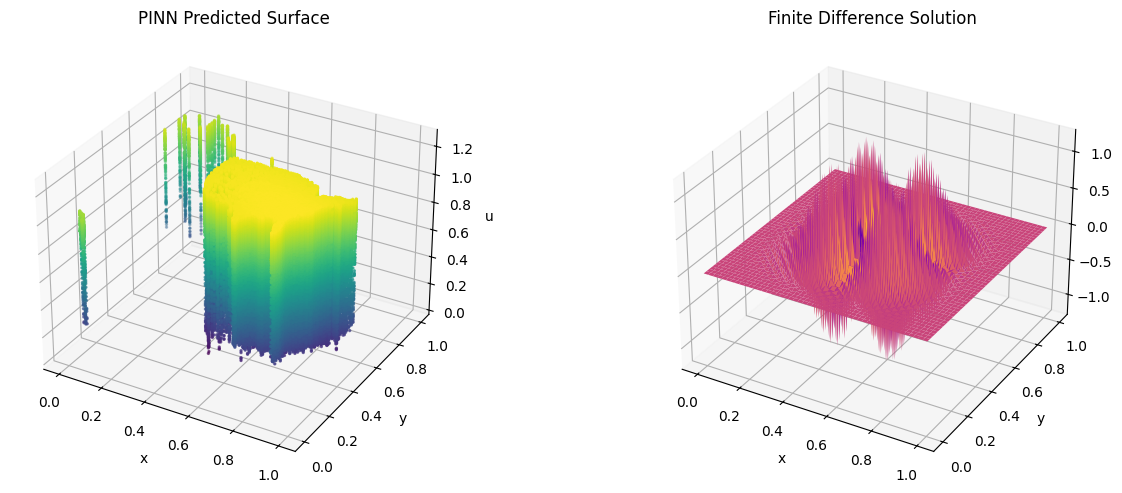

In [10]:
fig = plt.figure(figsize=(14, 5))


"""
3D surface plot of predicted u(x, y, t).
Applies inverse log1p to bring prediction to original scale.
"""
if isinstance(u_pred, torch.Tensor):
    u_plot = torch.expm1(u_pred).cpu().numpy()
else:
    u_plot = np.expm1(u_pred)

if isinstance(X_test, torch.Tensor):
    X_np = X_test.cpu().numpy()
else:
    X_np = X_test

ax1 = fig.add_subplot(1, 2, 1, projection="3d")
ax1.scatter(X_np[:, 0], X_np[:, 1], u_plot[:, 0], c=u_plot[:, 0], cmap="viridis", s=2)
ax1.set_title("PINN Predicted Surface")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_zlabel("u")

# FD Solution
ax2 = fig.add_subplot(1, 2, 2, projection="3d")
ax2.plot_surface(X_fd, Y_fd, u_fd, cmap="plasma")
ax2.set_title("Finite Difference Solution")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_zlabel("u")

plt.tight_layout()
plt.show()


In [11]:
import pickle
from utils import plot_loss_history

with open("checkpoints/loss_history.pkl", "rb") as f:
    loss_history = pickle.load(f)

plot_loss_history(loss_history)

NameError: name 'solver' is not defined

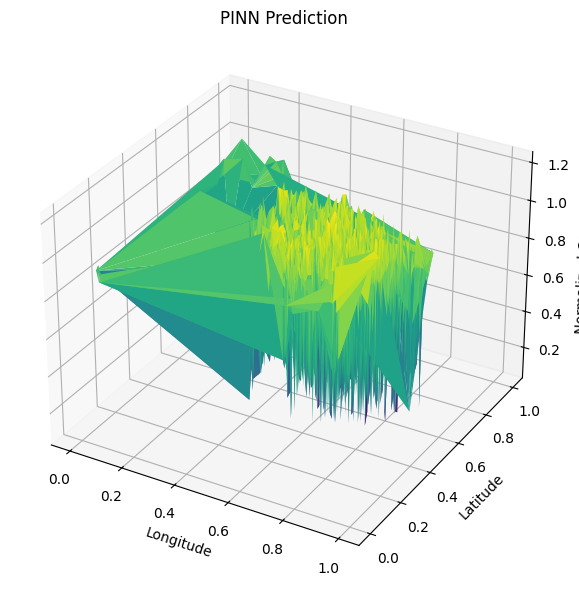

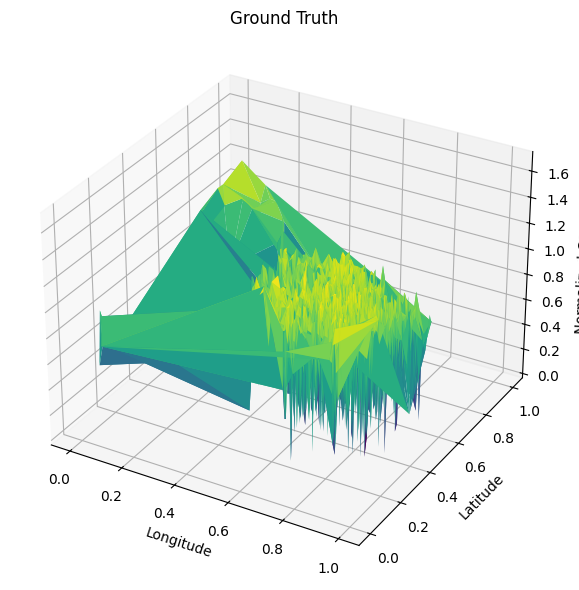

In [13]:
plot_prediction_surface(X_test, u_pred, title="PINN Prediction")
plot_prediction_surface(X_test, u_test, title="Ground Truth")


In [12]:
from utils import compute_errors, error_table

# Assuming u_pred and u_test are available
errors = compute_errors(u_pred.cpu().numpy(), u_test.cpu().numpy())
display(error_table(errors))


,Metric,Value
0,Relative L2 Error,7.02e-02
1,Max Abs Error,3.94e-01
